借助 Intel(R) Extension for Scikit-learn，您可以加速您的 Scikit-learn 应用程序，并且仍然完全符合所有 Scikit-Learn API 和算法。这是一款免费软件 AI 加速器，可为各种应用带来超过10-100 倍的加速。而且您甚至不需要更改现有代码！

In [2]:

   ## !python -m pip install pandas matplotlib scikit-learn-intelex scikit-learn openpyxl tensorboard seaborn ipykernel ipywidgets tensorflow mypy keras
 #tensorflow[and-cuda]

    

In [3]:
# 本导入顺序可以看到类型
import tensorflow as tf
# import tensorflow_datasets as tfds
import datetime
import os
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# from tensorflow import keras
import keras as keras
 
from keras import layers
from keras import models

from keras import backend as K

# K =keras.backend

patch_sklearn() 
# from attention_utils import get_activations

#更好地兼容 Python 3 的行为和特性，使得代码可以在 Python 2 和 Python 3 下运行得更加一致
# from __future__ import absolute_import,division,print_function,unicode_literals

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import tensorflow as tf
import datetime
print(' ')
print(f'{datetime.datetime.now()} tensorflow版本:', tf.__version__)
gpus = tf.config.experimental.list_physical_devices("GPU")
print(' ')
print('gpus： ')
print(gpus)
print(' ')
print('gpus')
# 查看系统中可见的GPU设备
print("Available GPU devices:", tf.config.list_physical_devices("GPU"))

 
2024-03-19 01:18:07.472897 tensorflow版本: 2.13.1
 
gpus： 
[]
 
gpus
Available GPU devices: []


In [5]:
refeshdata=False
if refeshdata or 'dfstate' not in locals() or (hasattr(locals()['dfstate'], 'empty') and locals()['dfstate'].empty):
    dfstate = pd.read_csv("./data/states.txt")
    dfstate["start"] = dfstate.apply(
        lambda row: row["date"] + " " + row["start_time"], axis=1
    )
    dfstate["end"] = dfstate.apply(lambda row: row["date"] + " " + row["end_time"], axis=1)
    dfstate["label"] = dfstate.pop("state").str.strip()
    # 转为时间类型
    dfstate[["start", "end"]] = dfstate[["start", "end"]].apply(pd.to_datetime)
    # dfstate["statev"] = dfstate.apply(label_to_number, axis=1)
    # dfstate['label'] = dfstate.apply(number_to_label,axis=1)
    dfstate.to_csv("./data/states.csv")
    print(dfstate.head(), dfstate.shape)


         date start_time  end_time               start                 end  \
0  2023-12-17   10:44:49  10:48:59 2023-12-17 10:44:49 2023-12-17 10:48:59   
1  2023-12-17   11:29:45  11:31:55 2023-12-17 11:29:45 2023-12-17 11:31:55   
2  2023-12-17   12:23:56  12:29:44 2023-12-17 12:23:56 2023-12-17 12:29:44   
3  2023-12-17   12:55:08  12:56:28 2023-12-17 12:55:08 2023-12-17 12:56:28   
4  2023-12-17   13:45:02  13:45:42 2023-12-17 13:45:02 2023-12-17 13:45:42   

  label  
0     装  
1     卸  
2     装  
3     卸  
4     装   (56, 6)


In [6]:
dfstate.head()

,date,start_time,end_time,start,end,label
0,2023-12-17,10:44:49,10:48:59,2023-12-17 10:44:49,2023-12-17 10:48:59,装
1,2023-12-17,11:29:45,11:31:55,2023-12-17 11:29:45,2023-12-17 11:31:55,卸
2,2023-12-17,12:23:56,12:29:44,2023-12-17 12:23:56,2023-12-17 12:29:44,装
3,2023-12-17,12:55:08,12:56:28,2023-12-17 12:55:08,2023-12-17 12:56:28,卸
4,2023-12-17,13:45:02,13:45:42,2023-12-17 13:45:02,2023-12-17 13:45:42,装


In [7]:
# 定义读取数据函数
def fix_data(inputDF: pd.DataFrame) -> pd.DataFrame:
    # 创建一个新的空列用于存储结果
    inputDF.insert(0, "before", False)
    inputDF.insert(0, "after", False)
    inputDF.insert(0, "label", "-")
    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():
        
        
        condition = (dfstate["start"] <= row["时间"]) & (row["时间"] <= dfstate["end"])
        match = dfstate[condition]
        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, "label"] = match["label"].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为-）
            pass
        
    # inputDF.insert(1,'state',0)
    # inputDF["state"] = inputDF["label"].astype("category").cat.codes
    return inputDF
def read_data(file_path: str) -> pd.DataFrame:
    return fix_data(
        pd.read_excel(file_path, engine="openpyxl", parse_dates=["时间", "轨迹时间"])
    )


# 读取数据
if refeshdata or 'odf17' not in locals() or (hasattr(locals()['odf17'], 'empty') and locals()['odf17'].empty):
    # 如果df未定义或为空DataFrame
    odf17 = read_data("./data/data_17.xlsx")
    odf21 = read_data("./data/data_21.xlsx")
    odf22 = read_data("./data/data_22.xlsx")
    odf23 = read_data("./data/data_23.xlsx")


组合数据集

In [8]:
numeric_col_names = ['原始重量', '稳定重量', '轴重', 'su_ad',
                     'wpu_x', 'wpu_y', 'wpu_z',
                     'su_x', 'su_y', 'su_z']
# delete some
#  "轨迹时间",'原始重量_diff', '稳定重量_diff', '轴重_diff','su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff','估计重量',    'su_x_diff','su_y_diff', 'su_z_diff',  ,
# ['原始重量', '稳定重量', '轴重', 'su_ad',
#                 'wpu_x', 'wpu_y', 'wpu_z',
#                 'su_x', 'su_y', 'su_z',
#                 '原始重量_diff', '稳定重量_diff', '轴重_diff',
#                 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff',
#                 'su_x_diff', 'su_y_diff', 'su_z_diff',
#                 '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶']
label_col_names = ["label"]
time_col_names = ["时间"]
feature_col_names = numeric_col_names  # 暂时去掉 时间
feature_col_num = len(feature_col_names)
categories = ["-", "装", "卸"]
class_num = len(categories)
print(class_num)
time_steps = 10

INPUT_DIMS_COlUMNS = feature_col_num


all_col_names = numeric_col_names + label_col_names + time_col_names
df17, df21, df22, df23 = odf17[all_col_names], odf21[all_col_names], odf22[all_col_names], odf23[all_col_names]
_origindata = pd.concat([df17, df21, df22], axis=0, ignore_index=True)

print(_origindata.columns)
print(_origindata.shape)
display(df17.shape, df22.shape, df23.shape, df23.shape)

_origindata.head()

3
Index(['原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z', 'su_x',
       'su_y', 'su_z', 'label', '时间'],
      dtype='object')
(69407, 12)


(16530, 12)

(27913, 12)

(27942, 12)

(27942, 12)

,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,su_y,su_z,label,时间
0,-4063,2020,-4375,33161,13662,326,76328,1867,-1010,87720,-,2023-12-17 09:39:23
1,-4175,2020,-4364,33160,13636,327,76355,1867,-1010,87720,-,2023-12-17 09:39:26
2,-4575,2020,-4486,33171,13649,312,76342,1867,-1005,87725,-,2023-12-17 09:39:30
3,-4330,2020,-4397,33163,13649,314,76342,1867,-999,87731,-,2023-12-17 09:39:32
4,-4442,2020,-4475,33170,13648,314,76343,1873,-1005,87720,-,2023-12-17 09:39:35


筛选数据，

In [9]:
def expandRows(idx_list_list, windowsize=20)->np.ndarray:
    my_array = np.arange(-windowsize, windowsize+1)
    new_array=idx_list_list.copy()
    for item in my_array:
        new_array += [element + item for element in indices_list]
    ret =np.sort(list(dict.fromkeys(new_array)))

    return ret

indices_list =_origindata.index[_origindata['label'] == '装'].tolist() + _origindata.index[_origindata['label'] == '卸'].tolist()
indices_list=expandRows(indices_list)

# 或者使用.iloc基于位置索引（如果是整数索引）
df_selected = _origindata.iloc[indices_list]

df_selected.head()

,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,su_y,su_z,label,时间
1231,-9307,0,-9786,33647,12697,-4264,76550,2988,3218,85407,-,2023-12-17 10:43:45
1232,-10766,0,-10654,33725,12739,-4197,76551,2971,3070,85561,-,2023-12-17 10:43:47
1233,-10654,0,-10677,33727,12724,-4167,76583,2966,3037,85605,-,2023-12-17 10:43:51
1234,-10632,0,-9753,33644,12715,-3882,76678,2955,2823,85753,-,2023-12-17 10:43:54
1235,-16595,0,-17179,34311,13123,-4439,76090,2642,2741,85995,-,2023-12-17 10:43:57


g:\dev\.anaconda\Miniconda\envs\py310_tf2.15.0\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
g:\dev\.anaconda\Miniconda\envs\py310_tf2.15.0\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
g:\dev\.anaconda\Miniconda\envs\py310_tf2.15.0\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
g:\dev\.anaconda\Miniconda\envs\py310_tf2.15.0\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
g:\dev\.anaconda\Miniconda\envs\py310_tf2.15.0\lib\site-packages\IPython\core\pylabtools.py:152: UserWar

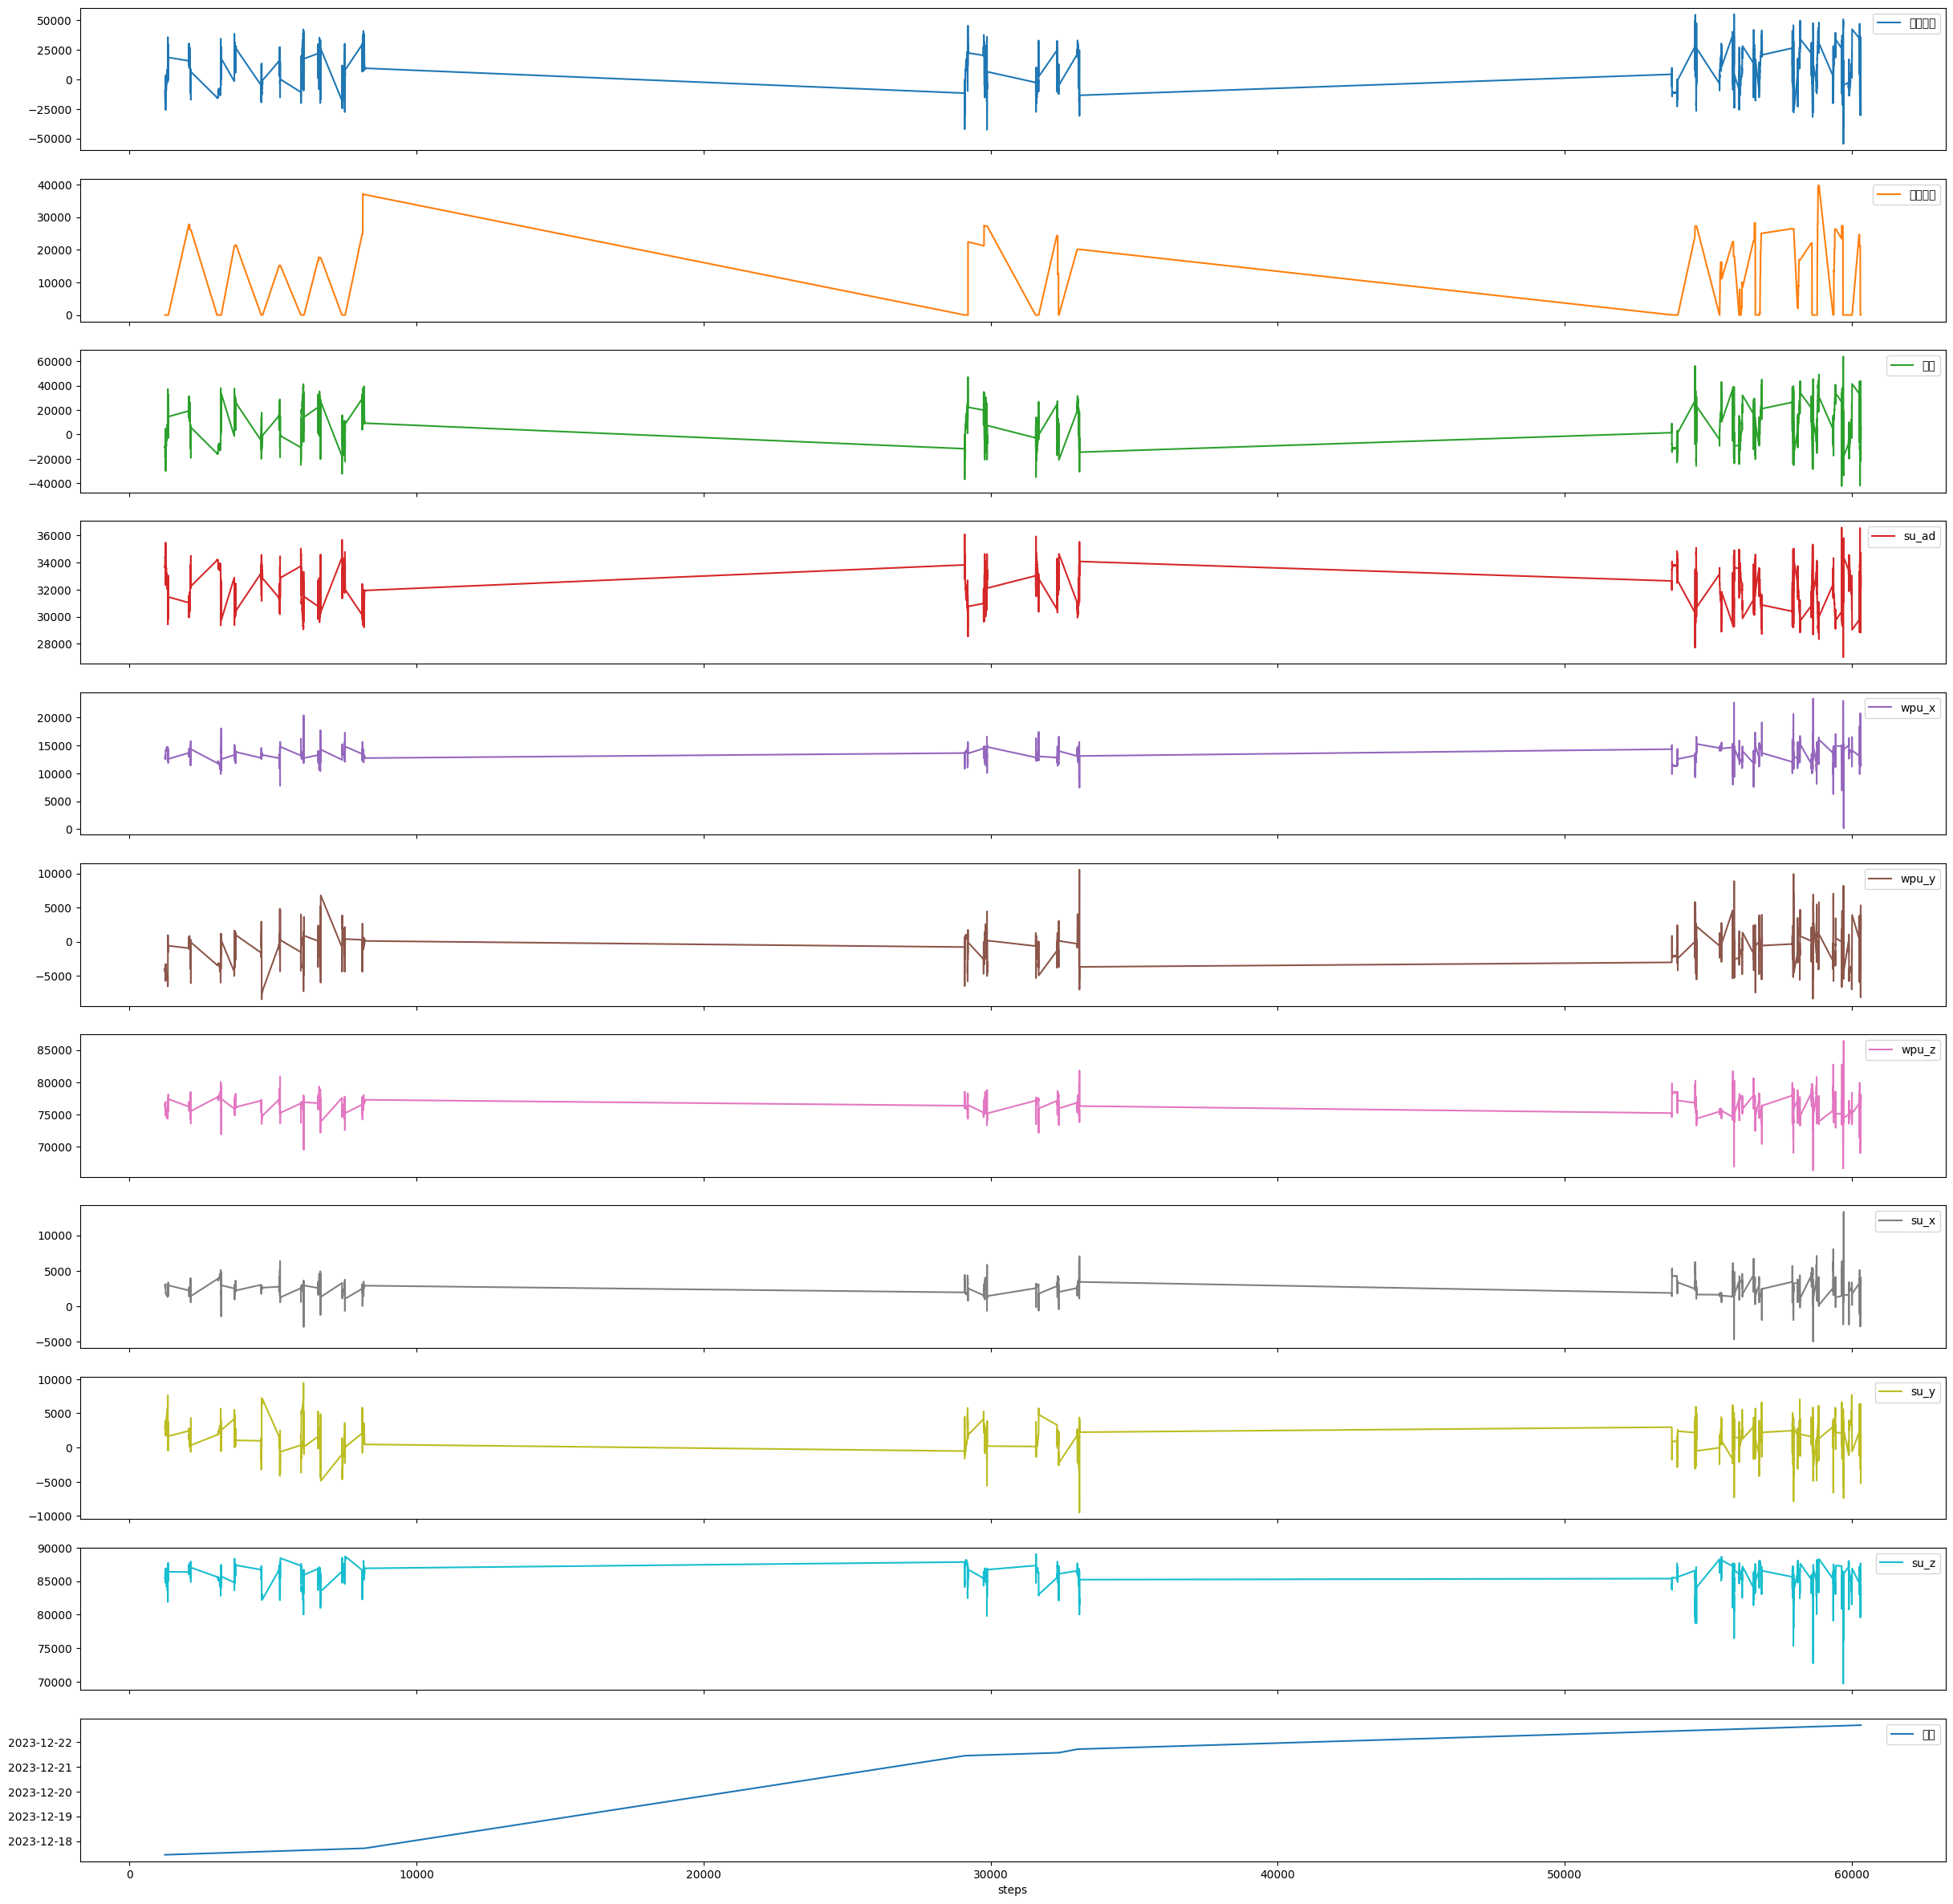

In [10]:
df_selected.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
ax = plt.gca()
# ax.set_xlim(left=0, right=7600)
# 或者直接指定字体文件路径
# plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 系统自带的黑体
# plt.rcParams['font.serif'] = ['DejaVu Sans']  # 系统自带的宋体
# plt.rcParams['font.family'] = ['DejaVu Sans']
plt.show()


### 归一化函数

In [11]:
from sklearn.preprocessing import OneHotEncoder


def normalize(
    inpudf: pd.DataFrame,
    numeric_col_names: list[str]
) -> np.ndarray: 
    # 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
    # 创建标准化器对象
    scaler = MinMaxScaler()
    return   scaler.fit_transform(inpudf)
    # for col in numeric_col_names :        
    #     result[col]=scaler.fit_transform(np.asarray(inpudf[col] ))
 

# def normalizeY(y: pd.DataFrame):
#     """对df中的数值列进行反标准化处理"""
#     # 定义一个字典，将标签映射到整数值
#     custom_label_dict = {    '-': 0, '卸': 1, '装': 2, }
#     le = OneHotEncoder(categories='auto', sparse=False)
#     print('mapping ---->',custom_label_dict)
#     # 现在我们可以将ydata转换为数值
#     ydata_numeric = y.apply(lambda x: custom_label_dict[x['label']],axis=1)
#     return ydata_numeric
def normalizeY(y: pd.DataFrame):
    """对df中的数值列进行反标准化处理"""
    # 定义一个字典，将标签映射到整数值
    ydata =np.asarray(y[label_col_names])
    le = OneHotEncoder()
    le.fit(ydata) 

    return le.transform(ydata),le


In [12]:
# class weights


from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series:np.ndarray, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    # class_count = [0] * n_classes
    # for classes in class_series:
    #     for index in range(n_classes):
    #         if classes[index] != 0:
    #             class_count[index] += 1
    
    class_count = np.array(class_series).sum(axis=0)
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

## feature归一化

In [13]:


scaler = MinMaxScaler()
xTrain=scaler.fit_transform(df_selected[feature_col_names])


print('参与训练的x data ：',xTrain.shape)
print("x列数:",feature_col_num)

xTrain

参与训练的x data ： (2942, 10)
x列数: 10


array([[0.41294592, 0.        , 0.30614376, ..., 0.43599562, 0.67173397,
        0.81210867],
       [0.39961064, 0.        , 0.29797842, ..., 0.43506565, 0.66392188,
        0.82007762],
       [0.40063432, 0.        , 0.29776206, ..., 0.43479212, 0.66217999,
        0.82235446],
       ...,
       [0.63996563, 0.        , 0.45056113, ..., 0.44261488, 0.30562154,
        0.74959897],
       [0.60190661, 0.        , 0.46659078, ..., 0.44228665, 0.44011613,
        0.69076326],
       [0.22407663, 0.        , 0.19428426, ..., 0.49245077, 0.60738981,
        0.53210867]])

## label归一化

In [14]:



def convert_to_int(data):
    return categories.index(data)


# convert to int
# ydata = data['label'].apply(convert_to_int).to_frame()


# 如果'label'已经是分类变量，可以直接转化
df_selected_label = df_selected[["label"]].copy()

# 确保'label'列是一个分类类型（如果还不是的话）
if not isinstance(df_selected_label["label"].dtype, pd.CategoricalDtype):
    df_selected_label["label"] = df_selected_label["label"].astype("category")
df_selected_label["label_v"] = df_selected_label["label"].apply(convert_to_int)
# le = OneHotEncoder()
# yTrain = le.fit_transform(df_selected_label)
yTrain = tf.one_hot(df_selected_label["label_v"], depth=class_num).numpy()

print("y data:", yTrain.shape)
print("y sample:")

# print(yTrain[0].dtype)
# for i in range(50):
print(yTrain)

y data: (2942, 3)
y sample:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [15]:
target = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))

# for features in target.take(1):
#    # image, label = features["image"], features["label"]
#     # print(type(image))
#     print(type(features))

# for window in target.window(time_steps).take(5):

#     print(window)

## 划分训练集和测试集

In [16]:
# tf_encoded_data = tf.convert_to_tensor(encoded_data_dense, dtype=tf.float32)

_y = yTrain

_x = xTrain.astype("float32")

print('---X--shape:', _x.shape)
display(_x[0:5])
print('---Y--shape:', _y.shape)

xInput, xTest, yInput, yTest = train_test_split(_x,
                                                _y,
                                                test_size=0.4,
                                                random_state=1)

# xInput,xTest=xInput.flatten(),xTest.flatten()

# for i in [10,27,54,59,83,91]:
#     _xtrain, _xv, _ytrain, _yv = train_test_split(_x,_y,
#                                             test_size=0.4,
#                                             shuffle=True,
#                                             random_state=i)
#     print('data shape:',_xtrain.shape, _xv.shape, _ytrain.shape, _yv.shape)
#     xtrain = np.concatenate((xtrain, _xtrain), axis=0)
#     ytrain = np.concatenate((ytrain, _ytrain), axis=0)
#     xv = np.concatenate((xv, _xv), axis=0)
#     yv = np.concatenate((yv, _yv), axis=0)

# print("ytrain value counts:",pd.Series(ytrain).value_counts())

# testWeight =generate_class_weights(ytrain,multi_class=True, one_hot_encoded=True)

# print(testWeight)
# print(xtrain)
# print(ytrain)
print('x train:', xInput.shape, 'y train data:', yInput.shape)

print('x vaild:', xTest.shape, 'y vaild:', yTest.shape)

---X--shape: (2942, 10)


array([[0.41294593, 0.        , 0.30614376, 0.6938626 , 0.5403229 ,
        0.22175556, 0.509118  , 0.43599564, 0.671734  , 0.8121087 ],
       [0.39961064, 0.        , 0.29797843, 0.70203185, 0.5421313 ,
        0.225273  , 0.50916773, 0.43506566, 0.6639219 , 0.8200776 ],
       [0.40063432, 0.        , 0.29776207, 0.7022413 , 0.5414855 ,
        0.22684796, 0.51075774, 0.43479213, 0.66218   , 0.82235444],
       [0.4008354 , 0.        , 0.30645418, 0.6935484 , 0.54109794,
        0.24181016, 0.51547825, 0.43419036, 0.65088415, 0.8300129 ],
       [0.34633347, 0.        , 0.23659727, 0.763406  , 0.5586652 ,
        0.21256825, 0.48626086, 0.41706783, 0.64655584, 0.84253556]],
      dtype=float32)

---Y--shape: (2942, 3)
x train: (1765, 10) y train data: (1765, 3)
x vaild: (1177, 10) y vaild: (1177, 3)


# （Embedding）的一些关键点

Embedding是一种在深度学习中常用的技术，它将输入数据（如单词、图像、句子等）映射到低维度的向量空间中。这种映射使得原始数据可以被模型更好地处理和理解。在自然语言处理（NLP）中，嵌入通常用于将单词或字符转换为固定大小的向量，这些向量可以捕捉词汇的语义和上下文信息

1.  **维度 reduction**: 嵌入将高维数据（如词汇表中的单词）映射到低维空间，使得模型可以更容易地处理。
    
2.  **固定大小**: 嵌入向量通常是固定大小的，这使得它们可以被矩阵操作，便于模型处理。
    
3.  **非线性**: 嵌入通常是通过对输入数据进行非线性变换来生成的，这有助于模型捕捉复杂的关系。
    
4.  **预训练和微调**: 在NLP中，单词嵌入通常预先训练然后在特定任务上微调。预训练可以捕获通用语义信息，而微调可以捕捉任务特定的信息。
    
5.  **神经网络**: 嵌入经常与神经网络一起使用，特别是卷积神经网络（CNN）和循环神经网络（RNN），以处理复杂的输入数据。
    
6.  **应用**: 除了NLP，嵌入技术还广泛应用于计算机视觉（如图像嵌入）、音频处理和其他领域。


## 模型创建

In [17]:
SINGLE_ATTENTION_VECTOR = False


def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    # a = Permute((2, 1))(inputs)
    # a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = layers.Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = layers.Lambda(lambda x: tf.reduce_mean(
            x, axis=1), name='dim_reduction')(a)
        a = layers.RepeatVector(input_dim)(a)
    a_probs = layers.Permute((1, 2), name='attention_vec')(a)  # 维数转置

    output_attention_mul = layers.concatenate(
        [inputs, a_probs], axis=-1)  # 把两个矩阵拼接
    return output_attention_mul


def attention_model(time_steps, input_dims, lstm_units,output_dim) -> keras.Model:
    inputs = layers.Input(shape=(time_steps, input_dims))

    x = layers.Conv1D(filters=64, kernel_size=1, activation='relu')(
        inputs)  # , padding = 'same'
    x = layers.Dropout(0.3)(x)

    # lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    # 对于GPU可以使用CuDNNLSTM
    lstm_out = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = layers.Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = layers.Flatten()(attention_mul)

    output = layers.Dense(output_dim, activation='sigmoid')(attention_mul)
    model = keras.Model(inputs=[inputs], outputs=output)
    return model

In [18]:
# model = models.Sequential(
#     [
#         keras.layers.Input(
#             batch_input_shape=(
#                 None,
#                 feature_col_num,
#             ),
#             name="input",
#         ),
#         layers.Dense(units=5,activation='relu'),
#         # layers.Conv1D(5, (3), activation=tf.nn.relu),
#         # layers.MaxPooling1D(pool_size=2),
#         layers.Dropout(drop),
#         # layers.Flatten(),
#         # layers.Dense(units=8, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
#         layers.Dense(
#             units=4,
#             activation=tf.nn.relu,
#             kernel_regularizer=keras.regularizers.l2(0.001),
#         ),
#         layers.Dense(units=1, activation="linear"),
#     ]
# ) 

## 编译模型

In [19]:
drop = 0.2

# 调整学习率
optimizer = keras.optimizers.Adam(learning_rate=0.2)  # 学习率设置为0.001
# model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

# print('xTrain.shape:', xTrain.shape)
# print('TIME_STEPS:', TIME_STEPS)
# print('INPUT_DIMS_COlUMNS:', INPUT_DIMS_COlUMNS)
# model:models.Model =attention_model(TIME_STEPS,INPUT_DIMS_COlUMNS)

# loss=keras.losses.mean_squared_error,

# model.compile(
#     optimizer=keras.optimizers.Adadelta(lr=0.002),
#     #loss=keras.losses.categorical_hinge,
#     loss=keras.losses.sparse_categorical_crossentropy(from_logits=True),
#     metrics=["AUC"]

# )
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# 损失函数, 优化器, 评价指标
# model.compile(loss=loss,
#             optimizer='adam',
#             metrics=['accuracy'])
# spec  = tf.TensorSpec(shape=[INPUT_DIMS_COlUMNS,], dtype=np.float32)

# ## ok run
# inputs = keras.Input(shape=(INPUT_DIMS_COlUMNS,),dtype=tf.float32,name='myinput')
# x = keras.layers.Dense(128, activation='relu')(inputs)
# x = keras.layers.Dense(64, activation='relu')(x)
# x = keras.layers.Dense(3, activation='sigmoid', name='myoutput')(x)
# outputs =keras.layers.Activation('softmax')(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

lstm_units = 64

model = attention_model(time_steps, INPUT_DIMS_COlUMNS, lstm_units, class_num)
cce = keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer='adam',
    loss=cce,
    metrics=['accuracy'],
    #   steps_per_execution=5
)

# iputlayer = model.input
# print(xInput.shape,'===',iputlayer.shape)

# print(xInput.dtype,'===',iputlayer.dtype)

# print('----------')
# oputlayer = model.output
# print(yInput.shape,'===',oputlayer.shape)
# print(yInput.dtype ,'===',oputlayer.dtype)
# print(yInput.dtype ,'===',oputlayer.dtype)
# print(tf.sparse.

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 10)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 10, 64)               704       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 10, 64)               0         ['conv1d[0][0]']              
                                                                                                  
 bidirectional (Bidirection  (None, 10, 128)              66048     ['dropout[0][0]']             
 al)                                                                                          

## 训练

In [35]:
def make_window_dataset(ds: tf.data.Dataset,
                        window_size=5,
                        shift=1,
                        stride=1) -> tf.data.Dataset:

    windows = ds.window(window_size, shift=shift, stride=stride,drop_remainder=True)

    def sub_to_batch(sub):
        return sub.batch(window_size, drop_remainder=True)

    windows = windows.flat_map(sub_to_batch)
    return windows


batch_size = feature_col_num * 1
batch_size = 5
epochs = 500

tf_callback = keras.callbacks.TensorBoard(log_dir="./logs")

target = tf.data.Dataset.from_tensor_slices(
    (df_selected[feature_col_names].values,
     df_selected[label_col_names].values))

# windowtarget = make_window_dataset(target, time_steps)

# def window_to_inputs_and_labels(window):
#     print(window)
#     inputs = window[:-1]  # 前 time_steps - 1 个元素作为输入
#     labels = window[-1]  # 最后一个元素作为标签
#     return (inputs, labels)  # 根据实际情况调整堆叠方式

# x, y = windowtarget.map(
#     lambda window: window_to_inputs_and_labels(window))

# print(x)
# train_dataset = train_dataset.map(window_to_inputs_and_labels)
# train_batches = list(train_dataset.)
# history = model.fit(
#     x,
#     y,
#     epochs=epochs,
#     verbose='auto',
#     batch_size=batch_size,
#     validation_split=0.5,

# callbacks=[tf_callback],
# class_weight=testWeight,
# workers=10
# )

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir "./logs"
# cmd 当前环境，当前目录 运行   tensorboard --logdir=logs --host=127.0.0.1
# 网页中可以查看模型训练过程

In [ ]:
import datetime
import os

# 获取当前时间
current_time = datetime.datetime.now()

# 将时间戳格式化为便于文件命名的形式
timestamp_str = current_time.strftime("%Y%m%d_%H%M%S")
file_name = f"./model_C_L_A_{timestamp_str}.h5"

if os.path.exists(file_name):
    # 以时间戳为序号命名文件，并保存模型
    model.save(file_name)

# # 如果你希望保存为txt、csv等其他格式的文件，可以这样操作
# with open(f'data_{timestamp_str}.txt', 'w') as f:
#     f.write('...')  # 写入你的数据或文本内容


In [ ]:
data22, scaler22 = normalize(
    df22, numeric_col_names
)

X22 = data22[feature_col_names]
Y22 =normalizeY( df22[label_col_names])
x_train22, y_train22 = np.asarray(X22), np.asarray(Y22)

xInput = x_train22.reshape(-1, feature_col_num)

# display(y_train22.shape )

# y_train22 = y_train22.reshape(-1, )

predY = model.predict(xInput, batch_size=batch_size)

# predY=predY.reshape(-1, )


In [ ]:
print("y_train22.shape", y_train22.shape)
print("predY.shape", predY.shape,predY.reshape(-1,))

In [ ]:
# data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# ax = plt.gca()
# ax.set_xlim(left=0, right=19000)



# # 或者直接指定字体文件路径
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 系统自带的黑体
# plt.rcParams['font.serif'] = ['SimSun']  # 系统自带的宋体
# plt.rcParams['font.family'] = ['SimSun','SimHei','Source Han Sans CN']



# plt.show()
times = df22[time_col_names].index.to_numpy()
display(times)
plt.plot(times, y_train22, label="Actual", marker="o")
plt.plot(times, predY, label="Predicted", linestyle="--", marker="x")



ax = plt.gca()
ax.set_xlim(left=12000, right=18000)
# 添加标题和标签
plt.title("Actual vs. Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")



# 添加图例
plt.legend()



# 显示图形
plt.show()

In [ ]:
# display(history.history)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "epoch", "accuracy"], loc="upper right")
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [ ]:
display(df22.columns)

In [ ]:
data22, scaler22 = normalize(df22, numeric_col_names)
X22 = data22[feature_col_names]
y_test22 =normalizeY( df22[label_col_names])
x_train22  = np.asarray(X22) .reshape(-1, feature_col_num) 
predY22 = model.predict(x_train22, batch_size=batch_size)


data23, scaler23 = normalize(df23, numeric_col_names) 
X23 = data23[feature_col_names]
y_test23 =normalizeY( df23[label_col_names])
x_train23  = np.asarray(X23) .reshape(-1, feature_col_num) 
predY23 = model.predict(x_train23, batch_size=batch_size)






display(predY22,predY23)

In [ ]:
fig_acc = plt.figure(figsize=(9, 9))
plt.plot(predY23[0:27000])
plt.plot(y_test23[0:27000])
plt.title("real vs pred")
plt.ylabel("value")
plt.xlabel("epoch")
plt.xlim((19000, 23000))
plt.legend(["pred", "real"], loc="upper left")
plt.show()